In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN")

In [2]:
from pyTVDN import TVDNDetect, TVDNRankTuning
from pyTVDN.tmpUtils import *
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import detrend
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import defaultdict as ddict
from tqdm import tqdm_notebook as tqdm
import pickle
from scipy.signal import lfilter, firls, decimate
%matplotlib inline
plt.style.use('ggplot')

In [3]:
saveDir = Path("./fMRIHPFs")
fils = list(saveDir.glob("*.pkl"))
fils = sorted(fils, key=lambda x: int(x.stem.split("_")[-1]))

In [4]:
import rpy2.robjects as robj
robj.r.source("../Rcode/utils.R")

RsegCorr = robj.r["segCorr"]
RsegPCA = robj.r["segPCA"]
RsegDMD = robj.r["DMD"]
RchgF = robj.r["chgF"]

# Distribution of num of changes and ranks

In [5]:
wsize = 10
rank = 6
numChgsw10 = ddict(list)
for fil in tqdm(fils):
    with open(fil, "rb") as f:
        res = pickle.load(f)
    Ymat = res.DetectObj.Ymat
    d, n = Ymat.shape
    seqw = np.arange(1, n-wsize, 4)
    rSeqw = py2Rvec(seqw)
    rYmat = py2Rmat(Ymat)
    
    
    rDCORres = RsegCorr(rYmat, wsize, rSeqw)
    rDCORecpts = RchgF(rDCORres, rSeqw)
    numChgsw10["DCOR"].append(np.array(rDCORecpts))
    
    # Detection results for PCA
    rPCAres = RsegPCA(rYmat, wsize, rSeqw, rank=rank)
    rPCAecpts = RchgF(rPCAres, rSeqw)
    numChgsw10["PCA"].append(np.array(rPCAecpts))
    
    # Detection results for DMD
    rDMDres = RsegDMD(rYmat, wsize, rSeqw, rank=rank)
    rDMDecpts = RchgF(rDMDres, rSeqw)
    numChgsw10["DMD"].append(np.array(rDMDecpts))

In [6]:
wsize = 20
rank = 6
numChgsw20 = ddict(list)
for fil in tqdm(fils):
    with open(fil, "rb") as f:
        res = pickle.load(f)
    Ymat = res.DetectObj.Ymat
    d, n = Ymat.shape
    seqw = np.arange(1, n-wsize, 4)
    rSeqw = py2Rvec(seqw)
    rYmat = py2Rmat(Ymat)
    
    # Detection results for DCOR
    rDCORres = RsegCorr(rYmat, wsize, rSeqw)
    rDCORecpts = RchgF(rDCORres, rSeqw)
    numChgsw20["DCOR"].append(np.array(rDCORecpts))
    
    # Detection results for PCA
    rPCAres = RsegPCA(rYmat, wsize, rSeqw, rank=rank)
    rPCAecpts = RchgF(rPCAres, rSeqw)
    numChgsw20["PCA"].append(np.array(rPCAecpts))
    
    # Detection results for DMD
    rDMDres = RsegDMD(rYmat, wsize, rSeqw, rank=rank)
    rDMDecpts = RchgF(rDMDres, rSeqw)
    numChgsw20["DMD"].append(np.array(rDMDecpts))

In [7]:
numChgs10CT = {}
numChgs20CT = {}
for key, v in numChgsw10.items():
    CT = Counter([len(ecpt) for ecpt in v])
    chgs = list(CT.keys())
    chgCts = [CT[chg] for chg in chgs]
    numChgs10CT[key] = [chgs, chgCts]
    
for key, v in numChgsw20.items():
    CT = Counter([len(ecpt) for ecpt in v])
    chgs = list(CT.keys())
    chgCts = [CT[chg] for chg in chgs]
    numChgs20CT[key] = [chgs, chgCts]

### Ranks and num of changes for TVDN

In [9]:
numChgs = []
numRanks = []
for fil in fils:
    with open(fil, "rb") as f:
        res = pickle.load(f)
    numChgs.append(len(res.DetectObj.ecpts))
    numRanks.append(res.optRank)
    
numChgsCt = Counter(numChgs)
numRanksCt = Counter(numRanks)

ranks = list(numRanksCt.keys())
ranks = sorted(ranks)
rCts = [numRanksCt[r] for r in ranks]

chgs = list(numChgsCt.keys())
chgCts = [numChgsCt[chg] for chg in chgs]

Text(-0.05, 0.16, 'wsize=20')

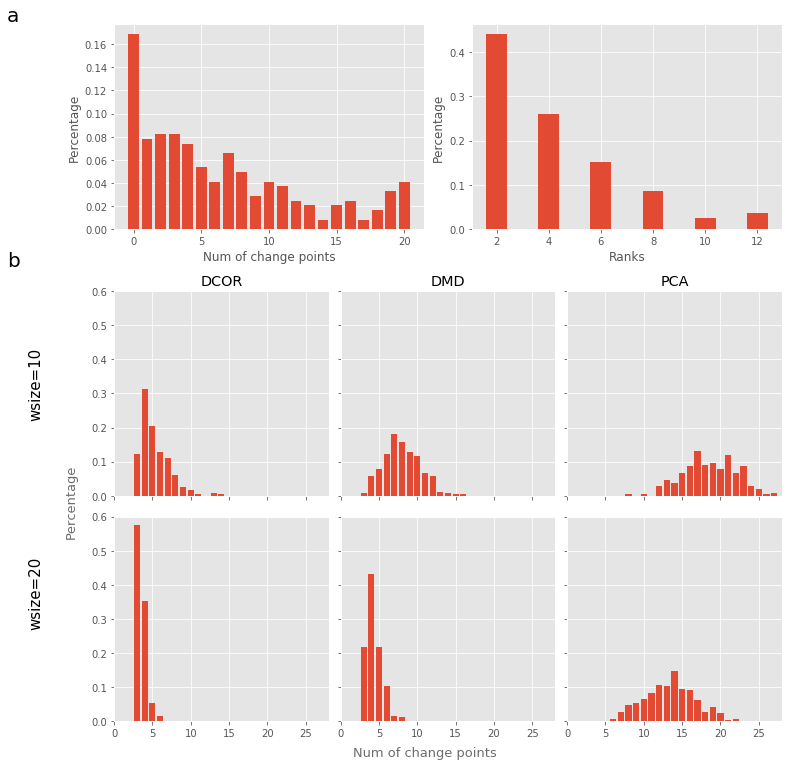

In [141]:
from matplotlib import gridspec

fig = plt.figure(figsize=(10, 10), constrained_layout=True)

gs = gridspec.GridSpec(3, 6, figure=fig)

ax0 = plt.subplot(gs[0,0:3])
ax0.bar(chgs, np.array(chgCts)/len(fils))
ax0.set_xlabel("Num of change points")
ax0.set_ylabel("Percentage")


ax1 = plt.subplot(gs[0,3:6])
ax1.bar(ranks, np.array(rCts)/len(fils))
ax1.set_xlabel("Ranks")
ax1.set_ylabel("Percentage")

ax2 = plt.subplot(gs[1,0:2])
ax2.bar(numChgs10CT["DCOR"][0], np.array(numChgs10CT["DCOR"][1])/len(fils))
ax2.set_ylim([0, 0.6])
ax2.set_xlim([0, 28])
ax2.set_title("DCOR")
ax2.tick_params(labelbottom=False)

ax3 = plt.subplot(gs[1,2:4], sharex=ax2, sharey=ax2)
ax3.bar(numChgs10CT["DMD"][0], np.array(numChgs10CT["DMD"][1])/len(fils))
ax3.set_title("DMD")
ax3.tick_params(labelleft=False, labelbottom=False)

ax4 = plt.subplot(gs[1,4:6], sharex=ax2, sharey=ax2)
ax4.bar(numChgs10CT["PCA"][0], np.array(numChgs10CT["PCA"][1])/len(fils))
ax4.set_title("PCA")
ax4.tick_params(labelleft=False, labelbottom=False)

ax5 = plt.subplot(gs[2,0:2], sharex=ax2, sharey=ax2)
ax5.bar(numChgs20CT["DCOR"][0], np.array(numChgs20CT["DCOR"][1])/len(fils))

ax6 = plt.subplot(gs[2,2:4], sharex=ax2, sharey=ax2)
ax6.bar(numChgs20CT["DMD"][0], np.array(numChgs20CT["DMD"][1])/len(fils))
ax6.tick_params(labelleft=False)

ax7 = plt.subplot(gs[2,4:6], sharex=ax2, sharey=ax2)
ax7.bar(numChgs20CT["PCA"][0], np.array(numChgs20CT["PCA"][1])/len(fils))
ax7.tick_params(labelleft=False)


fig.text(-0.08, 1, "a", fontsize=20)
fig.text(-0.08, 0.66, "b", fontsize=20)

fig.text(0.5, -0.02, 'Num of change points', ha='center', fontsize=13, color="#6D6D6D")
fig.text(0, 1/3, 'Percentage', va='center', rotation="vertical", fontsize=13, color="#6D6D6D")

fig.text(-0.05, 0.45, "wsize=10", rotation="vertical", fontsize=15)
fig.text(-0.05, 0.16, "wsize=20", rotation="vertical", fontsize=15)

# Correlation with the 7 canonical networks

In [95]:
import pandas as pd

def tmpF(name):
    splName = name.split("_")
    if len(splName) == 1:
        return splName[0]
    else:
        res = splName[0] 
        for splNam in splName[1:]:
            res = res + " " + splNam
        return res 

fcR = pd.read_csv("../necessary files/AALICA.csv")
names = list(fcR.columns)
names = [tmpF(name.strip()) for name in names]
fcR = np.array(fcR)
fcR = fcR[:90, :]

RsegDMDOrg = robj.r["DMDOrg"]
RsegPCAOrg = robj.r["segPCAOrg"]
RcorF = robj.r["corF.fMRI"]

In [58]:
wsize = 10
rank = 6
featuresW10 = ddict(list)
corW10 = ddict(list)
for fil in tqdm(fils):
    with open(fil, "rb") as f:
        res = pickle.load(f)
    Ymat = res.DetectObj.Ymat
    d, n = Ymat.shape
    seqw = np.arange(1, n-wsize, 4)
    rSeqw = py2Rvec(seqw)
    rYmat = py2Rmat(Ymat)
    rfcR = py2Rmat(fcR)
    
    # Features and correlations for PCA
    rPCAres = RsegPCAOrg(rYmat, wsize, rSeqw, rank=rank)
    featuresW10["PCA"].append(np.array(rPCAres))
    rPCAres = RcorF(rPCAres, rfcR)
    corW10["PCA"].append(np.array(rPCAres))
    
    # Features and correlations for DMD
    rDMDres = RsegDMDOrg(rYmat, wsize, rSeqw, rank=rank)
    featuresW10["DMD"].append(np.array(rDMDres))
    rDMDres = RcorF(rDMDres, rfcR)
    corW10["DMD"].append(np.array(rDMDres))

In [59]:
wsize = 20
rank = 6
corW20 = ddict(list)
featuresW20 = ddict(list)
for fil in tqdm(fils):
    with open(fil, "rb") as f:
        res = pickle.load(f)
    Ymat = res.DetectObj.Ymat
    d, n = Ymat.shape
    seqw = np.arange(1, n-wsize, 4)
    rSeqw = py2Rvec(seqw)
    rYmat = py2Rmat(Ymat)
    rfcR = py2Rmat(fcR)
    
    # Features for PCA
    rPCAres = RsegPCAOrg(rYmat, wsize, rSeqw, rank=rank)
    featuresW20["PCA"].append(np.array(rPCAres))
    rPCAres = RcorF(rPCAres, rfcR)
    corW20["PCA"].append(np.array(rPCAres))
    
    # Features  results for DMD
    rDMDres = RsegDMDOrg(rYmat, wsize, rSeqw, rank=rank)
    featuresW20["DMD"].append(np.array(rDMDres))
    rDMDres = RcorF(rDMDres, rfcR)
    corW20["DMD"].append(np.array(rDMDres))

In [67]:
DMDw10Cors = np.array(corW10["DMD"]).reshape(-1, 7)
PCAw10Cors = np.array(corW10["PCA"]).reshape(-1, 7)
DMDw20Cors = np.array(corW20["DMD"]).reshape(-1, 7)
PCAw20Cors = np.array(corW20["PCA"]).reshape(-1, 7)
TVDNCors = np.loadtxt("./midRess/allCorr.txt")

DMDw10CorM = np.max(DMDw10Cors, axis=1)
PCAw10CorM = np.max(PCAw10Cors, axis=1)
DMDw20CorM = np.max(DMDw20Cors, axis=1)
PCAw20CorM = np.max(PCAw20Cors, axis=1)
TVDNCorM = np.max(TVDNCors, axis=1)

In [68]:
rawVs = list(TVDNCorM) + list(DMDw10CorM) + list(DMDw20CorM) + list(PCAw10CorM) + list(PCAw20CorM)
labs = ["TVDN"]*len(absTVDNCorM) + ["DMD wsize=10"]* len(absDMDw10CorM) + ["DMD wsize=20"]* len(absDMDw20CorM) + \
       ["PCA wsize=10"]*len(absPCAw10CorM) +  ["PCA wsize=20"]*len(absPCAw20CorM)

In [71]:
maxPosIdxDMDw10 = np.argmax(DMDw10Cors, axis=1)
maxPosIdxPCAw10 = np.argmax(PCAw10Cors, axis=1)
maxPosIdxDMDw20 = np.argmax(DMDw20Cors, axis=1)
maxPosIdxPCAw20 = np.argmax(PCAw20Cors, axis=1)
maxPosIdxTVDN = np.argmax(TVDNCors, axis=1)

PosPCAw10CT = Counter(maxPosIdxPCAw10)
PosDMDw10CT = Counter(maxPosIdxDMDw10)
PosPCAw20CT = Counter(maxPosIdxPCAw20)
PosDMDw20CT = Counter(maxPosIdxDMDw20)
PosTVDNCT = Counter(maxPosIdxTVDN)
barPosPCAw10 = [PosPCAw10CT[i]/len(maxPosIdxPCAw10) for i in range(7)]
barPosDMDw10 = [PosDMDw10CT[i]/len(maxPosIdxDMDw10) for i in range(7)]
barPosPCAw20 = [PosPCAw20CT[i]/len(maxPosIdxPCAw20) for i in range(7)]
barPosDMDw20 = [PosDMDw20CT[i]/len(maxPosIdxDMDw20) for i in range(7)]
barPosTVDN = [PosTVDNCT[i]/len(maxPosIdxTVDN) for i in range(7)]

Text(-0.05, 0.1, 'wsize=20')

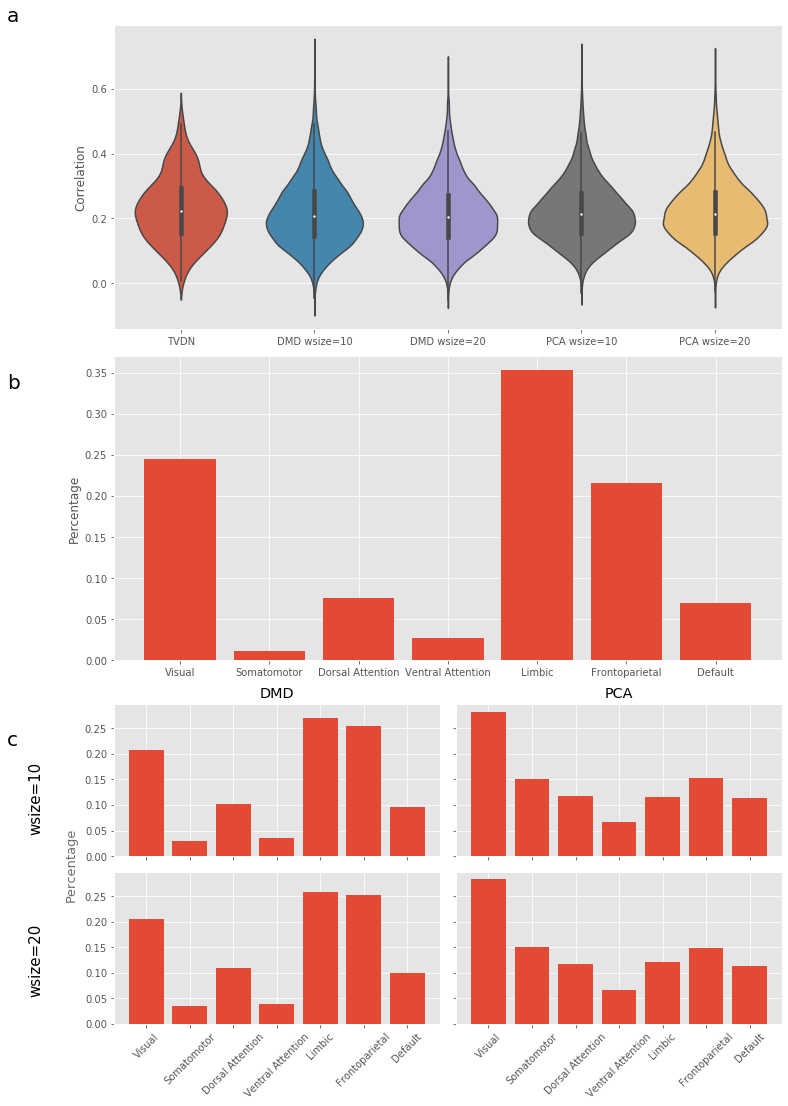

In [140]:
fig = plt.figure(figsize=(10, 15), constrained_layout=True)

gs = gridspec.GridSpec(6, 2, figure=fig)

ax0 = plt.subplot(gs[0:2,0:2])
sns.violinplot(y=rawVs, x=labs)
_ = plt.ylabel("Correlation")

ax1 = plt.subplot(gs[2:4,0:2])
ax1.bar(names, barPosTVDN)
ax1.set_ylabel("Percentage")

ax2 = plt.subplot(gs[4, 0])
ax2.bar(names, barPosDMDw10)
ax2.set_title("DMD")
ax2.tick_params(labelbottom=False)

ax3 = plt.subplot(gs[4, 1], sharex=ax2, sharey=ax2)
ax3.bar(names, barPosPCAw10)
ax3.set_title("PCA")
ax3.tick_params(labelbottom=False, labelleft=False)


ax4 = plt.subplot(gs[5, 0], sharex=ax2, sharey=ax2)
ax4.bar(names, barPosDMDw20)
ax4.set_xticklabels(names, rotation=45)

ax5 = plt.subplot(gs[5, 1], sharex=ax2, sharey=ax2)
ax5.bar(names, barPosPCAw20)
ax5.tick_params(labelleft=False)
ax5.set_xticklabels(names, rotation=45)

fig.text(-0.08, 1, "a", fontsize=20)
fig.text(-0.08, 0.66, "b", fontsize=20)
fig.text(-0.08, 0.33, "c", fontsize=20)

fig.text(0, 0.22, 'Percentage', va='center', rotation="vertical", fontsize=13, color="#6D6D6D")

fig.text(-0.05, 0.25, "wsize=10", rotation="vertical", fontsize=15)
fig.text(-0.05, 0.10, "wsize=20", rotation="vertical", fontsize=15)

## fMRI 15

In [214]:
idx = 14
with open(fils[idx], "rb") as f:
    res = pickle.load(f)

### Results for DCOR, DMD and PCA

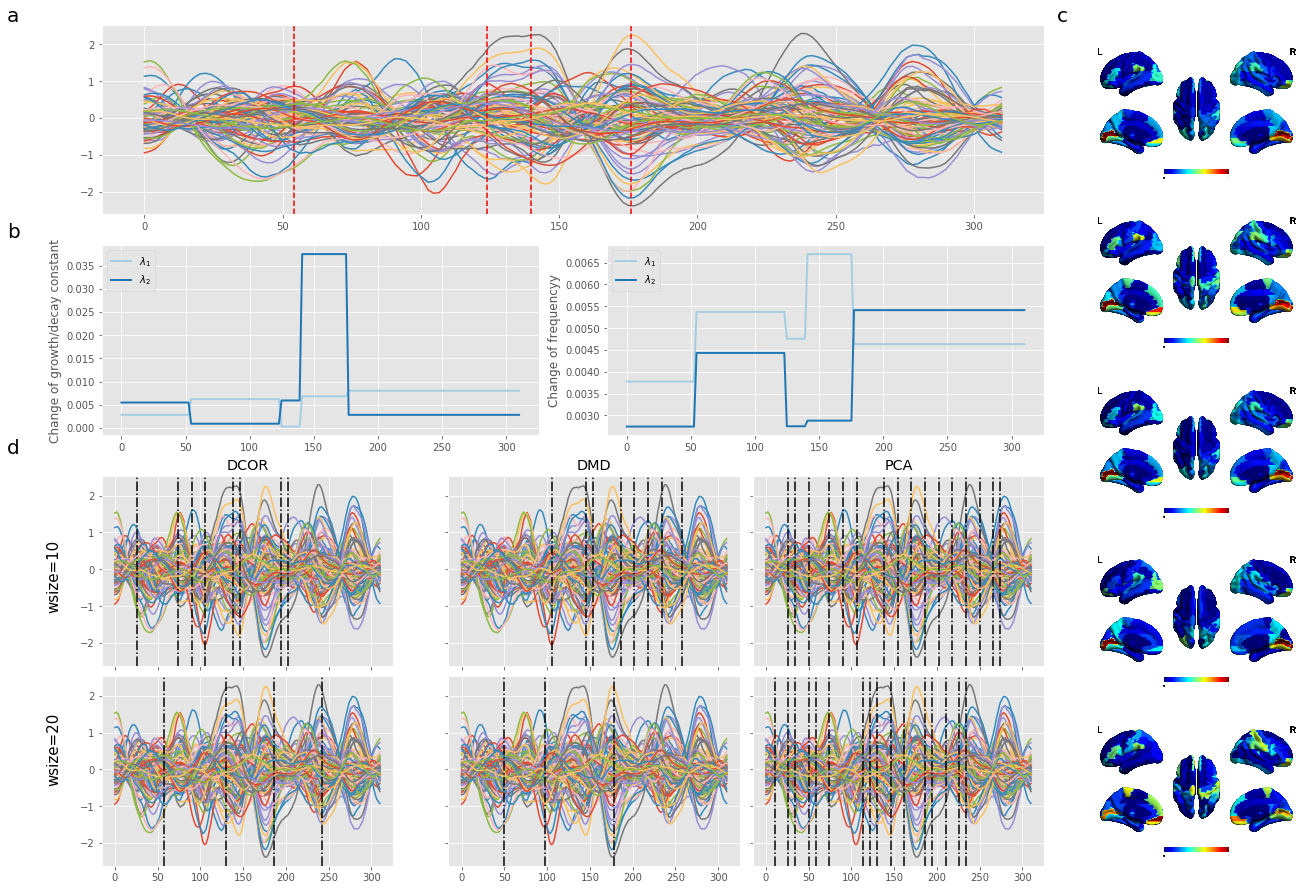

In [236]:
d, n = res.DetectObj.nYmat.shape
acTime = n / res.DetectObj.paras.freq
ajfct = n/acTime
ptime = res.DetectObj.ptime
Ymat = res.DetectObj.Ymat
brainDir = Path("../Rcode/brainsPlot")
brainPlots = list(brainDir.glob("fMRI15*.jpg"))
brainPlots = sorted(brainPlots, key=lambda x: int(x.stem.split("_")[-1]))

detObj = res.DetectObj
freq = detObj.paras.freq
numChgCur = len(detObj.ecpts)
LamMs = detObj.RecResCur.LamMs
rAct, n = LamMs.shape
pltIdxs = np.arange(1, rAct)[np.diff(np.abs(LamMs), axis=0).astype(np.bool).all(axis=1)] 
pltIdxs = np.concatenate([[0], pltIdxs])
ReLamMs = freq*LamMs.real/(acTime/detObj.paras.T)
ImLamMs = freq*LamMs.imag/((2*np.pi)*(acTime/detObj.paras.T))
cols = sns.color_palette("Paired", len(pltIdxs))

fig = plt.figure(figsize=(18, 12), constrained_layout=True)
gs = gridspec.GridSpec(20, 8, figure=fig)

ax0 = plt.subplot(gs[0:5, :6])
for i in range(d):
    ax0.plot(ptime, Ymat[i, :], "-")
for ecpt in res.DetectObj.ecpts:
    ax0.axvline(ecpt/ajfct, color="red", linestyle="--")
#ax0.set_xlabel("Time")

ax1 = plt.subplot(gs[0:4,   6:])
ax2 = plt.subplot(gs[4:8,   6:])
ax3 = plt.subplot(gs[8:12,  6:])
ax4 = plt.subplot(gs[12:16, 6:])
ax5 = plt.subplot(gs[16:20, 6:])

img = plt.imread(brainPlots[0])
ax1.imshow(img)
ax1.axis("off")

img = plt.imread(brainPlots[1])
ax2.imshow(img)
ax2.axis("off")

img = plt.imread(brainPlots[2])
ax3.imshow(img)
ax3.axis("off")

img = plt.imread(brainPlots[3])
ax4.imshow(img)
ax4.axis("off")

img = plt.imread(brainPlots[4])
ax5.imshow(img)
ax5.axis("off")


ax6 = plt.subplot(gs[5:10, :3])
for i0, i in enumerate(pltIdxs):
    labs = f"$\\lambda_{i0+1}$"
    ax6.plot(detObj.ptime, np.abs(ReLamMs[i, :]), label=labs,  color=cols[i0], linewidth=2)
ax6.set_ylabel("Change of growth/decay constant")
#ax6.set_xlabel("Time")
ax6.legend(loc="upper left")

ax7 = plt.subplot(gs[5:10, 3:6])
for i0, i in enumerate(pltIdxs):
    labs = f"$\\lambda_{i0+1}$"
    ax7.plot(detObj.ptime, np.abs(ImLamMs[i, :]), label=labs, 
             color=cols[i0], linewidth=2)
ax7.set_ylabel("Change of frequencyy")
#ax7.set_xlabel("Time")
ax7.legend(loc="upper left")

ax8 = plt.subplot(gs[10:15,  0:2])
ax9 = plt.subplot(gs[10:15,  2:4])
ax10 = plt.subplot(gs[10:15, 4:6])
ax11 = plt.subplot(gs[15:20,  0:2])
ax12 = plt.subplot(gs[15:20,  2:4])
ax13 = plt.subplot(gs[15:20, 4:6])

for i in range(d):
    ax8.plot(ptime, Ymat[i, :], "-")
for ecpt in numChgsw10["DCOR"][idx]:
    ax8.axvline(ecpt/ajfct, color="black", linestyle="-.")
ax8.set_title("DCOR")
ax8.set_xticklabels([])

for i in range(d):
    ax9.plot(ptime, Ymat[i, :], "-")
for ecpt in numChgsw10["DMD"][idx]:
    ax9.axvline(ecpt/ajfct, color="black", linestyle="-.")
ax9.set_title("DMD")
ax9.set_xticklabels([])
ax9.set_yticklabels([])

for i in range(d):
    ax10.plot(ptime, Ymat[i, :], "-")
for ecpt in numChgsw10["PCA"][idx]:
    ax10.axvline(ecpt/ajfct, color="black", linestyle="-.")
ax10.set_title("PCA")
ax10.set_xticklabels([])
ax10.set_yticklabels([])

for i in range(d):
    ax11.plot(ptime, Ymat[i, :], "-")
for ecpt in numChgsw20["DCOR"][idx]:
    ax11.axvline(ecpt/ajfct, color="black", linestyle="-.")

for i in range(d):
    ax12.plot(ptime, Ymat[i, :], "-")
for ecpt in numChgsw20["DMD"][idx]:
    ax12.axvline(ecpt/ajfct, color="black", linestyle="-.")
ax12.set_yticklabels([])

for i in range(d):
    ax13.plot(ptime, Ymat[i, :], "-")
for ecpt in numChgsw20["PCA"][idx]:
    ax13.axvline(ecpt/ajfct, color="black", linestyle="-.")
ax13.set_yticklabels([])

fig.text(0, 0.32, "wsize=10", rotation="vertical", fontsize=15)
_ = fig.text(0, 0.12, "wsize=20", rotation="vertical", fontsize=15)

fig.text(-0.03, 1, "a", fontsize=20)
fig.text(-0.03, 0.75, "b", fontsize=20)
fig.text(0.78, 1, "c", fontsize=20)
_ = fig.text(-0.03, 0.50, "d", fontsize=20)